___

> ### AI Impact analysis - experiments

____

In [1]:
# Imports
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
import numpy as np

from typing import List
from scipy.optimize import curve_fit

In [2]:
# to remove warnings
warnings.filterwarnings('ignore')

# Power : KW
# Rmax/Rpeak : GFlops
# Energy efficiency : Gflops/Watts

In [3]:
def get_rank_year(year):
    y, m = year.split('-')
    if 11 > int(m) >= 6 :
        return y + '-' + '06'
    elif int(m) >= 11:
        return y + '-' + '11'
    else:
        return str(int(y)-1) + '-' + '11'


___


In [4]:
# uploading the green500 and top500 data
top500_df = pd.read_csv('data/top500_data.csv')
green500_df = pd.read_csv('data/green500_data.csv')

# uploading the carbon intensity of each country by year for our next analysis
carbon_df = pd.read_csv('./data/carbon_intensity_by_country.csv')
carbon_df[carbon_df['Entity'] == 'France']
carbon_df['Country'] = carbon_df['Entity']

# adding the carbon intensity
green500_df = green500_df.merge(carbon_df, on=['Year', 'Country'])

In [5]:
# adding some useful columns for our analysis : electric consumption, carbon footprint and GFlop/KgCO2
green500_df['electric_consumption (GWh)'] = green500_df['Power'] * 365.25 * 24 / 1e6
green500_df['Carbon footprint (TCO2)'] = green500_df['Carbon intensity of electricity - gCO2/kWh'] * green500_df['electric_consumption (GWh)']  # Kg co2 per GWh
green500_df['GFlops/KgCO2'] = green500_df['RMax'] * 365.25 * 24 * 3600 / (green500_df['Carbon footprint (TCO2)'] * 1000) # Gflop per KgCO2

In [6]:
ai_df = pd.read_csv('data/ai_training_computation.csv')
ai_df = ai_df[ai_df['Day'] >= '1994-11-01']
ai_df['Day']= pd.to_datetime(ai_df['Day'])
ai_df['y_m'] = ai_df['Day'].dt.strftime('%Y-%m')
ai_df['rank_year'] = ai_df['y_m'].apply(get_rank_year)
ai_df.head()

,Entity,Code,Day,Training computation (petaFLOP),Domain,y_m,rank_year
0,(ensemble): AWD-LSTM-DOC (fin) × 5 (WT2),NaN,2018-08-30,693.00000,Language,2018-08,2018-06
1,2-layer-LSTM+Deep-Gradient-Compression,NaN,2017-12-05,1.34000,Language,2017-12,2017-11
2,3D city reconstruction,NaN,2009-09-29,NaN,Other,2009-09,2009-06
3,4 layer QRNN (h=2500),NaN,2018-03-22,240.00002,Language,2018-03,2017-11
4,6-Act Tether,NaN,2021-08-03,NaN,Other,2021-08,2021-06


In [7]:
top_df = top500_df[['rank_year', 'RMax', 'RPeak']].groupby('rank_year').max().reset_index()
top_df_tmp = green500_df[['rank_year', 'G_eff', 'RMax']].groupby('rank_year').agg({'G_eff':'max'}).reset_index()
top_df_g = green500_df[['rank_year', 'G_eff', 'RMax', 'Power']]
top_df_g = top_df_tmp.merge(top_df_g, how="inner")


In [8]:
cc_df = pd.DataFrame.merge(ai_df, top_df, on='rank_year', how='left')
cc_df_g = pd.DataFrame.merge(ai_df, top_df_g, on='rank_year', how='left')
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Entity                           729 non-null    object        
 1   Code                             0 non-null      float64       
 2   Day                              729 non-null    datetime64[ns]
 3   Training computation (petaFLOP)  317 non-null    float64       
 4   Domain                           729 non-null    object        
 5   y_m                              729 non-null    object        
 6   rank_year                        729 non-null    object        
 7   RMax                             663 non-null    float64       
 8   RPeak                            663 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 51.4+ KB


Text(201.22631401909723, 0.5, 'Training computation (petaFLOP)')

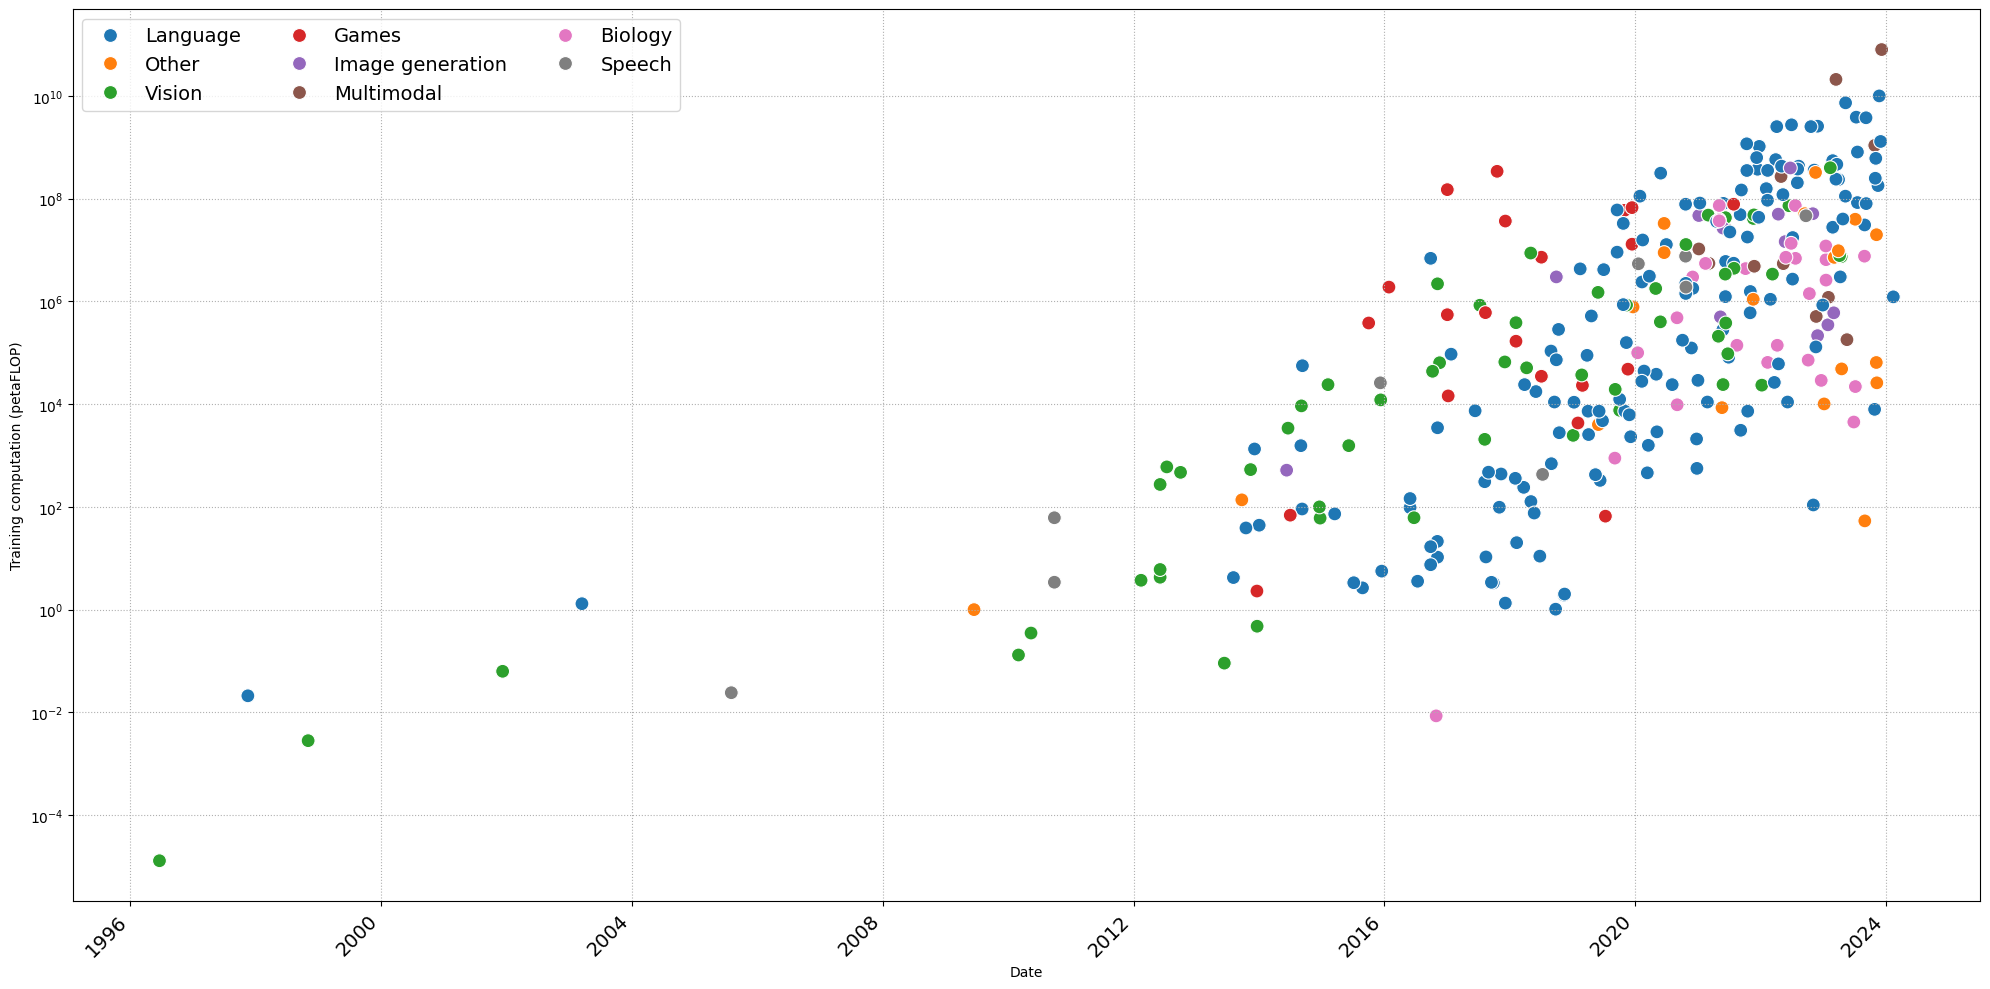

In [9]:
plt.figure(figsize=(20, 10))
plt.grid(linestyle='dotted') 
plt.yscale('log')
sns.scatterplot(data=cc_df, x='Day', y='Training computation (petaFLOP)',  markers=True, hue='Domain', s=100)


# Axis settings
plt.legend(ncol=3, loc=2,fontsize='14')
plt.xticks(
        rotation=45, ha='right', fontsize=14
    )
plt.tight_layout()

plt.xlabel(r'Date')
plt.ylabel(r'Training computation (petaFLOP)')

In [10]:
cc_df['hrs_computation'] = 1e6 * cc_df['Training computation (petaFLOP)'] / (cc_df['RMax'])
cc_df_g['hrs_computation'] = 1e6 * cc_df_g['Training computation (petaFLOP)'] / (cc_df_g['RMax'])

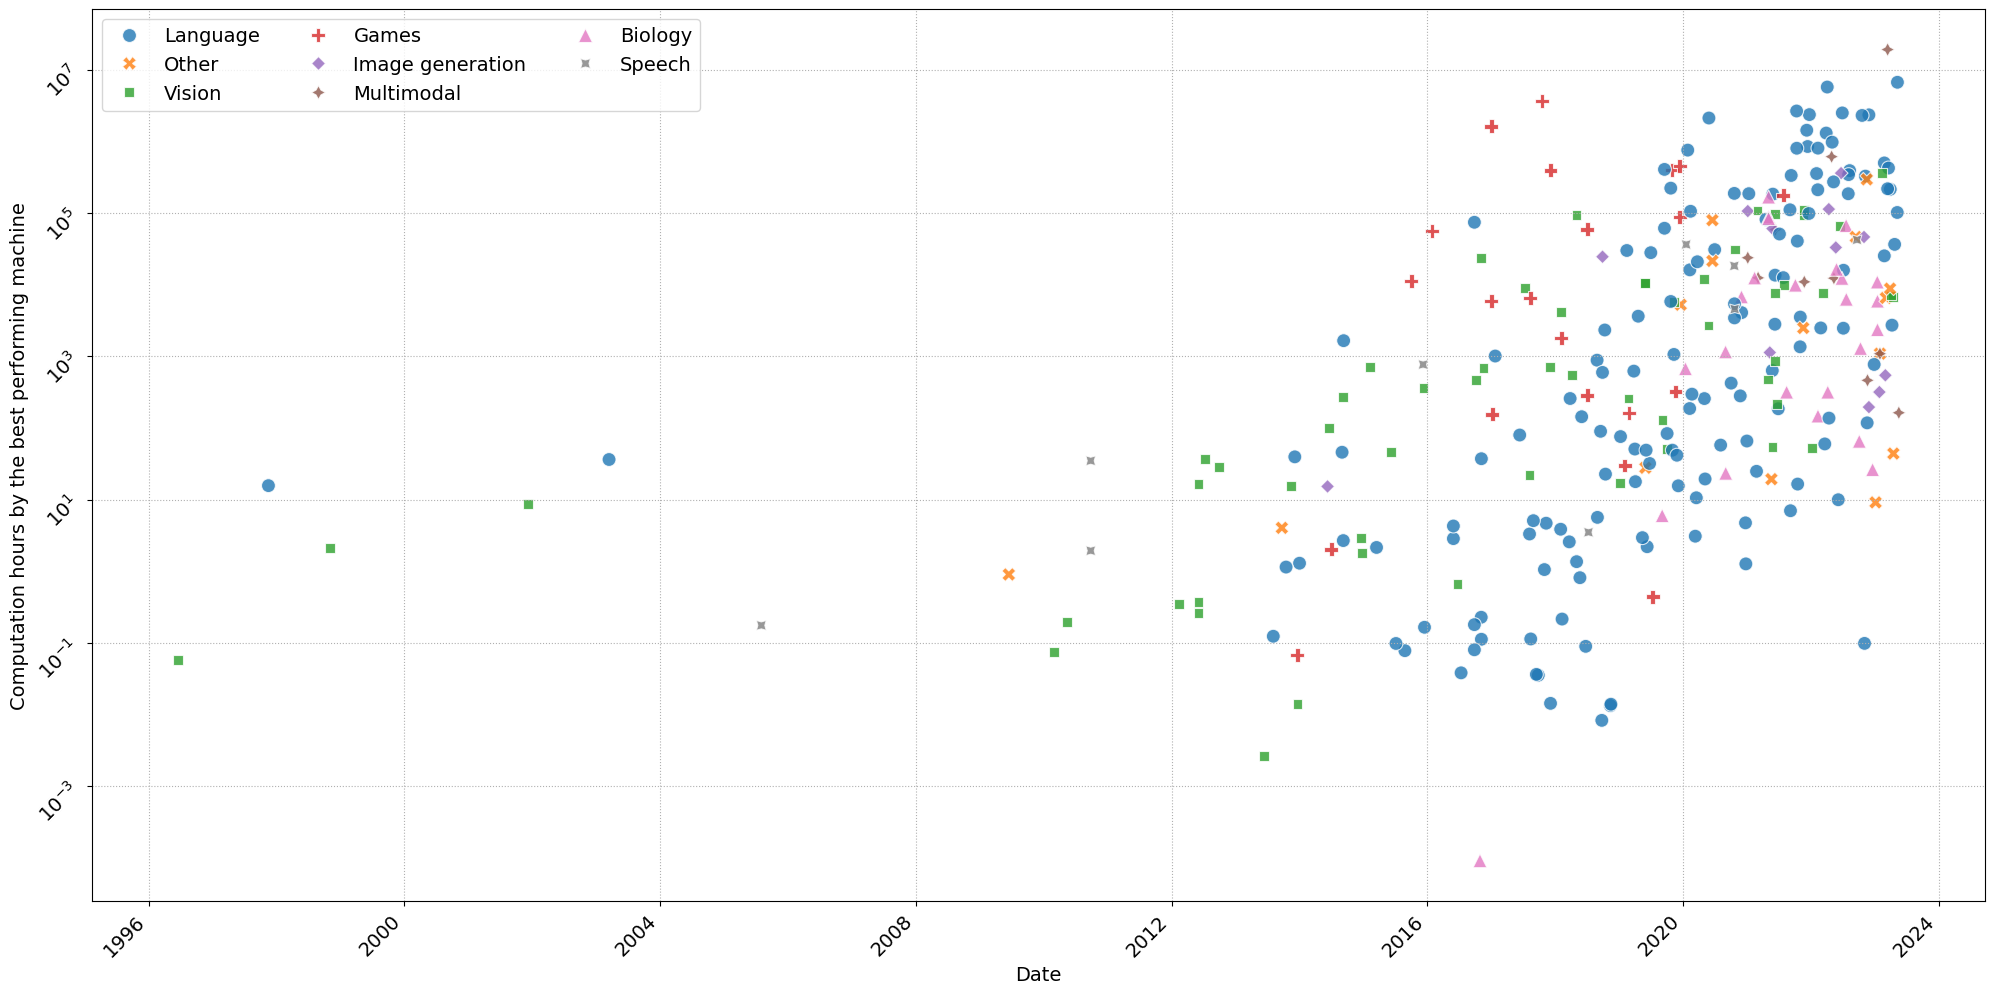

In [11]:
plt.figure(figsize=(20, 10))
plt.grid(linestyle='dotted') 
plt.yscale('log')

sns.scatterplot(data=cc_df, x='Day', y='hrs_computation',  markers=True, hue='Domain', style="Domain",  s=100, alpha=0.8)

# for x,y in zip(cc_df['Day'],cc_df['hrs_computation']):

#     label = cc_df[cc_df['Day'] == x]['Entity']
#     print(str(cc_df[cc_df['Day'] == x]['Entity']))

#     plt.annotate(label, # this is the text
#                  (x,y), # these are the coordinates to position the label
#                  textcoords="offset points", # how to position the text
#                  xytext=(0,10), # distance from text to points (x,y)
#                  ha='center') 


# Axis settings
plt.legend(ncol=3, loc=2,fontsize='14')
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(rotation=45, ha='right', fontsize=14)
plt.tight_layout()

plt.xlabel(r'Date', fontsize=14)
plt.ylabel(r'Computation hours by the best performing machine', fontsize=14)

plt.savefig('figures/hrs_computation_by_ai_models.png', format='png', bbox_inches="tight")

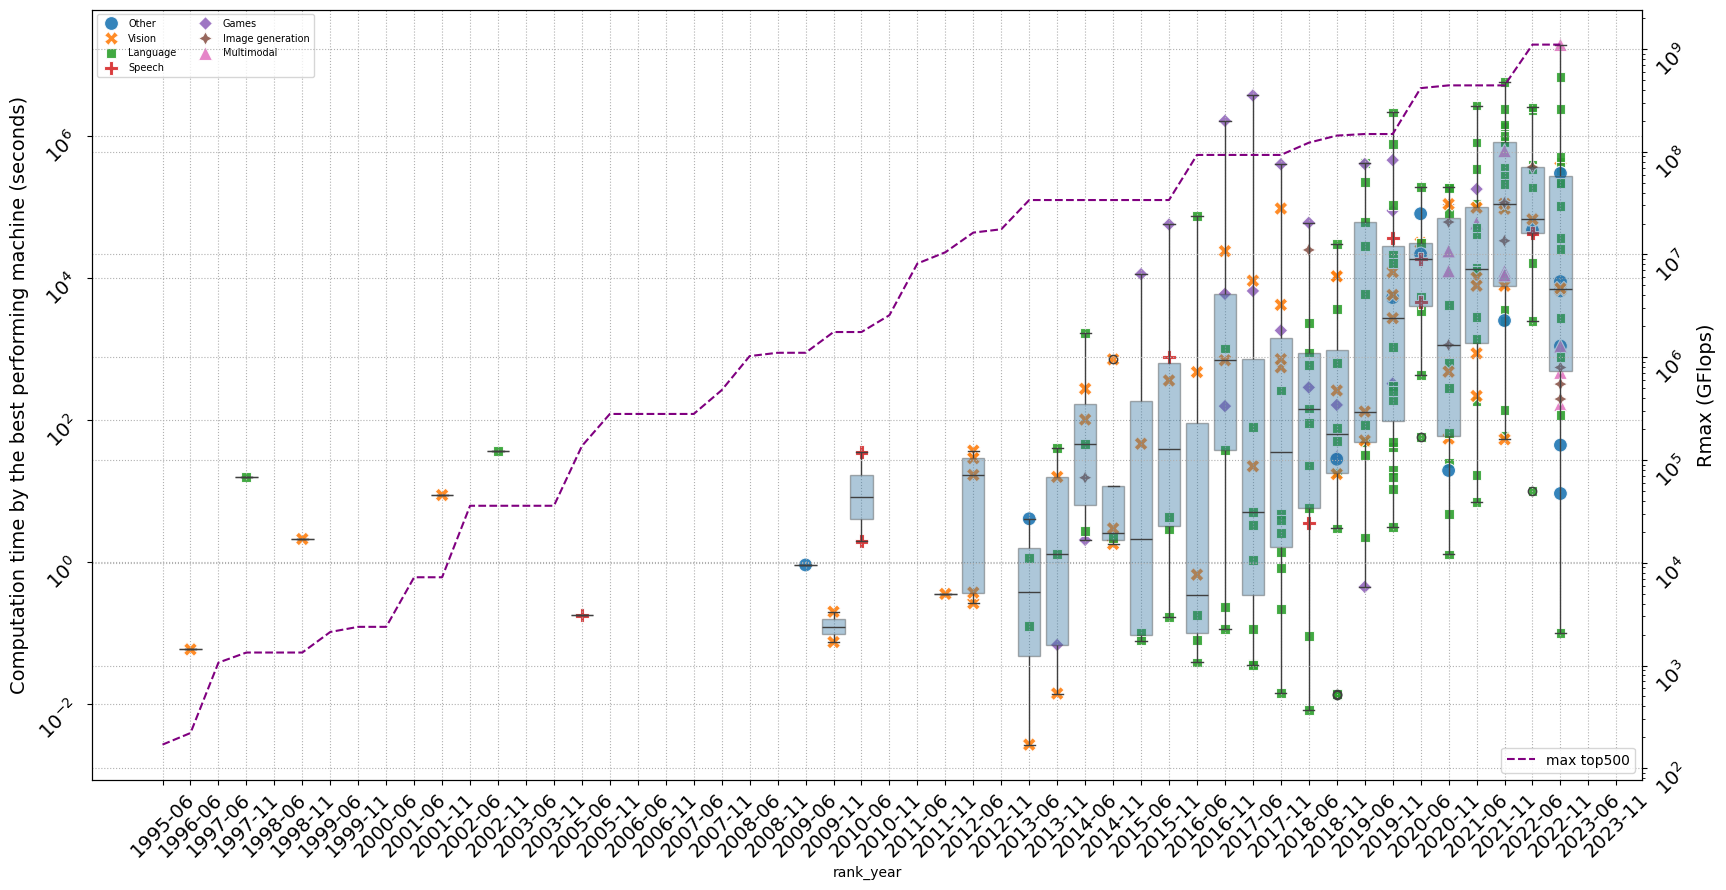

In [12]:

#plt.figure(figsize=(20, 10))
fig, ax = plt.subplots(figsize=(20, 10))

plt.grid(linestyle='dotted') 
plt.yscale('log')

cc_df= cc_df.sort_values(['rank_year'])
cc_df.reset_index(drop=True, inplace=True)
cc_df = cc_df[cc_df.Domain != 'Biology']

#ax = sns.lineplot(data=cc_df[['rank_year', 'hrs_computation']].groupby('rank_year').max().reset_index(), x='rank_year', y='hrs_computation', label='max computation hrs', color='grey')
sns.boxplot(data=cc_df[['rank_year', 'hrs_computation']], x='rank_year', y='hrs_computation',  boxprops=dict(alpha=.4), ax=ax)
sns.scatterplot(data=cc_df, x='rank_year', y='hrs_computation',  markers=True, hue='Domain', style="Domain",  s=100, alpha=0.9, ax=ax)

ax2 = ax.twinx()
ax2.set_yscale('log')
ax2 = sns.lineplot(data=cc_df[['rank_year', 'RMax']].groupby('rank_year').max().reset_index(), x='rank_year', y='RMax', label='max top500', color='purple', linestyle='--', ax=ax2)

for axx in [ax, ax2]:
    #axx.xaxis.set_major_locator(loc)
    
    axx.set_yscale('log')
    axx.grid(linestyle='dotted')
    axx.tick_params(labelrotation=45, labelsize=7)
    axx.legend(ncol=2, loc=2, fontsize="7")

ax.set_ylabel('Computation time by the best performing machine (seconds)', fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

ax2.set_ylabel('Rmax (GFlops)', fontsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.legend(loc=4)
# Axis settings
# plt.legend(ncol=3, loc=2,fontsize='14')
# plt.xticks(rotation=45, ha='right', fontsize=14)
# plt.yticks(rotation=45, ha='right', fontsize=14)
# plt.tight_layout()

plt.xlabel(r'Date', fontsize=14)
#plt.ylabel(r'Computation hours by the best performing machine', fontsize=14)

plt.savefig('figures/sec_computation_by_ai_models.png', format='png', bbox_inches="tight")

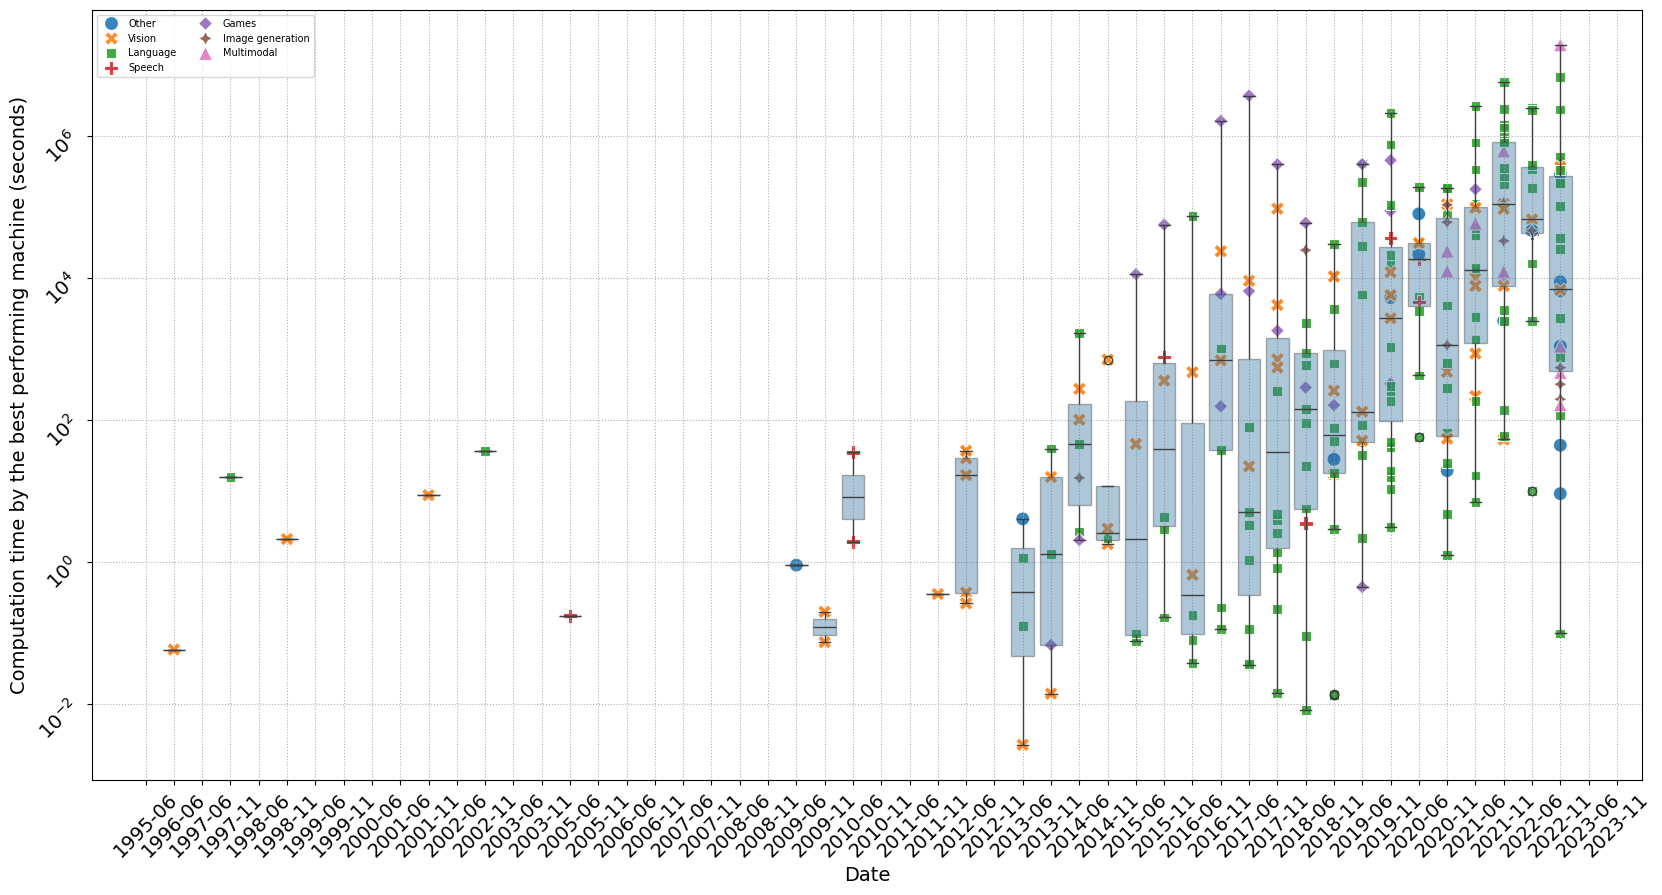

In [13]:

#plt.figure(figsize=(20, 10))
fig, ax = plt.subplots(figsize=(20, 10))

plt.grid(linestyle='dotted') 
plt.yscale('log')

cc_df= cc_df.sort_values(['rank_year'])
cc_df.reset_index(drop=True, inplace=True)
cc_df = cc_df[cc_df.Domain != 'Biology']

#ax = sns.lineplot(data=cc_df[['rank_year', 'hrs_computation']].groupby('rank_year').max().reset_index(), x='rank_year', y='hrs_computation', label='max computation hrs', color='grey')
sns.boxplot(data=cc_df[['rank_year', 'hrs_computation']], x='rank_year', y='hrs_computation',  boxprops=dict(alpha=.4), ax=ax)
sns.scatterplot(data=cc_df, x='rank_year', y='hrs_computation',  markers=True, hue='Domain', style="Domain",  s=100, alpha=0.9, ax=ax)

#ax2 = ax.twinx()
#ax2.set_yscale('log')
#ax2 = sns.lineplot(data=cc_df[['rank_year', 'RMax']].groupby('rank_year').max().reset_index(), x='rank_year', y='RMax', label='max top500', color='purple', linestyle='--', ax=ax2)

for axx in [ax, ax2]:
    axx.set_yscale('log')
    axx.grid(linestyle='dotted')
    axx.tick_params(labelrotation=45, labelsize=7)
    axx.legend(ncol=2, loc=2, fontsize="7")

ax.set_ylabel('Computation time by the best performing machine (seconds)', fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

ax2.set_ylabel('Rmax (GFlops)', fontsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.legend(loc=4)
# Axis settings
# plt.legend(ncol=3, loc=2,fontsize='14')
# plt.xticks(rotation=45, ha='right', fontsize=14)
# plt.yticks(rotation=45, ha='right', fontsize=14)
# plt.tight_layout()

plt.xlabel(r'Date', fontsize=14)
#plt.ylabel(r'Computation hours by the best performing machine', fontsize=14)

plt.savefig('figures/sec_computation_by_ai_models.png', format='png', bbox_inches="tight")

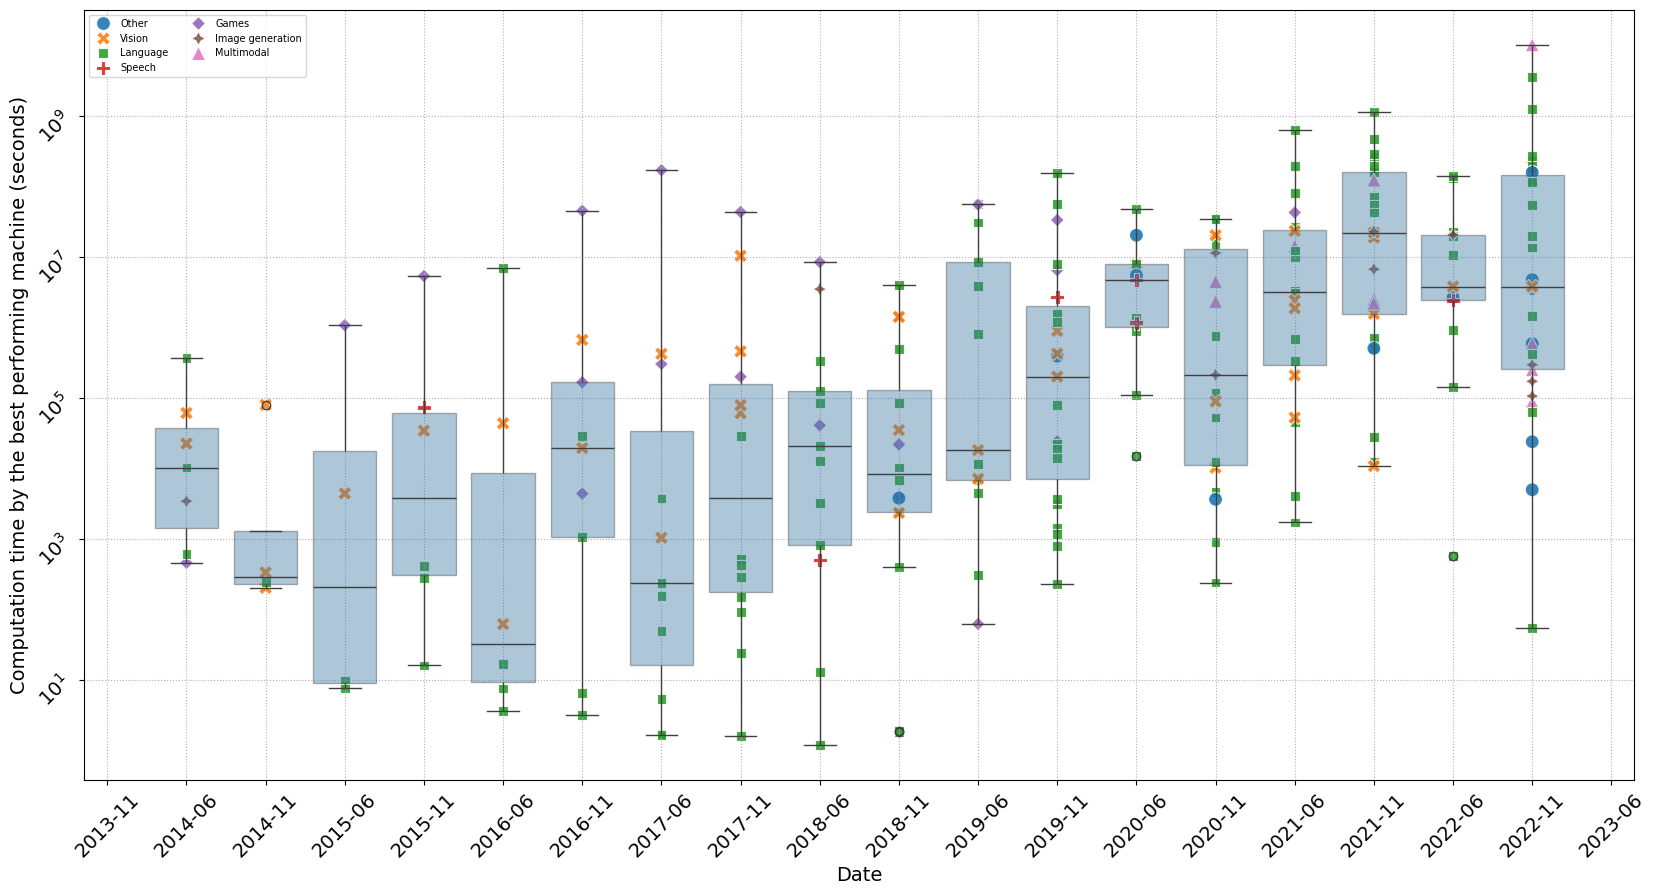

In [14]:

#plt.figure(figsize=(20, 10))
fig, ax = plt.subplots(figsize=(20, 10))

plt.grid(linestyle='dotted') 
plt.yscale('log')

cc_df_g= cc_df_g.sort_values(['rank_year'])
cc_df_g.reset_index(drop=True, inplace=True)
cc_df_g = cc_df_g[cc_df_g.Domain != 'Biology']

#ax = sns.lineplot(data=cc_df[['rank_year', 'hrs_computation']].groupby('rank_year').max().reset_index(), x='rank_year', y='hrs_computation', label='max computation hrs', color='grey')
sns.boxplot(data=cc_df_g[['rank_year', 'hrs_computation']], x='rank_year', y='hrs_computation',  boxprops=dict(alpha=.4), ax=ax)
sns.scatterplot(data=cc_df_g, x='rank_year', y='hrs_computation',  markers=True, hue='Domain', style="Domain",  s=100, alpha=0.9, ax=ax)

#ax2 = ax.twinx()
#ax2.set_yscale('log')
#ax2 = sns.lineplot(data=cc_df[['rank_year', 'RMax']].groupby('rank_year').max().reset_index(), x='rank_year', y='RMax', label='max top500', color='purple', linestyle='--', ax=ax2)

for axx in [ax, ax2]:
    axx.set_yscale('log')
    axx.grid(linestyle='dotted')
    axx.tick_params(labelrotation=45, labelsize=7)
    axx.legend(ncol=2, loc=2, fontsize="7")

ax.set_ylabel('Computation time by the best performing machine (seconds)', fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

ax2.set_ylabel('Rmax (GFlops)', fontsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.legend(loc=4)
# Axis settings
# plt.legend(ncol=3, loc=2,fontsize='14')
# plt.xticks(rotation=45, ha='right', fontsize=14)
# plt.yticks(rotation=45, ha='right', fontsize=14)
# plt.tight_layout()

plt.xlabel(r'Date', fontsize=14)
#plt.ylabel(r'Computation hours by the best performing machine', fontsize=14)

plt.savefig('figures/sec_green_computation_by_ai_models.png', format='png', bbox_inches="tight")

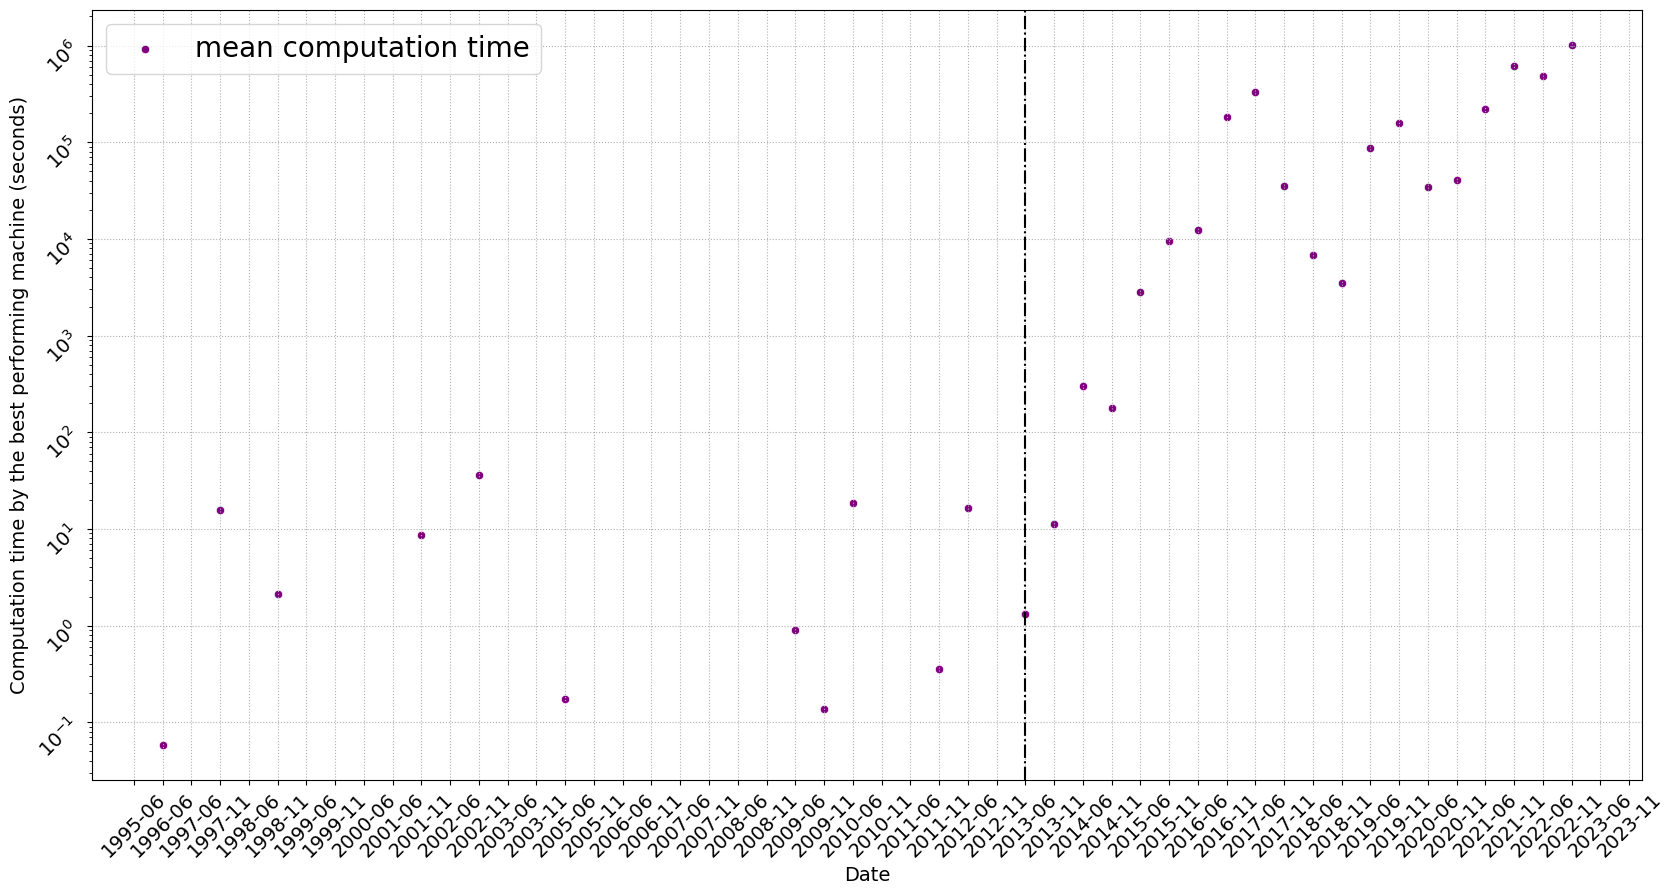

In [15]:

#plt.figure(figsize=(20, 10))
fig, ax = plt.subplots(figsize=(20, 10))

plt.grid(linestyle='dotted') 
plt.yscale('log')

cc_df= cc_df.sort_values(['rank_year'])
cc_df.reset_index(drop=True, inplace=True)
cc_df = cc_df[cc_df.Domain != 'Biology']

ax = sns.scatterplot(data=cc_df[['rank_year', 'hrs_computation']].groupby('rank_year').mean().reset_index(), x='rank_year', y='hrs_computation', label='mean computation time', color='purple')
#sns.lineplot(data=cc_df[['rank_year', 'hrs_computation']].groupby('hrs_computation').mean().reset_index(), x='rank_year', y='hrs_computation',  boxprops=dict(alpha=.4), ax=ax)
#sns.scatterplot(data=cc_df, x='rank_year', y='hrs_computation',  markers=True, hue='Domain', style="Domain",  s=100, alpha=0.9, ax=ax)

plt.axvline(x = "2013-06", color = 'black', linestyle='-.')

#ax2 = ax.twinx()
#ax2.set_yscale('log')
#ax2 = sns.lineplot(data=cc_df[['rank_year', 'RMax']].groupby('rank_year').max().reset_index(), x='rank_year', y='RMax', label='max top500', color='purple', linestyle='--', ax=ax2)

for axx in [ax, ax2]:
    axx.set_yscale('log')
    axx.grid(linestyle='dotted')
    axx.tick_params(labelrotation=45, labelsize=7)
    axx.legend(ncol=2, loc=2, fontsize="20")

ax.set_ylabel('Computation time by the best performing machine (seconds)', fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

ax2.set_ylabel('Rmax (GFlops)', fontsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.legend(loc=4)
# Axis settings
# plt.legend(ncol=3, loc=2,fontsize='14')
# plt.xticks(rotation=45, ha='right', fontsize=14)
# plt.yticks(rotation=45, ha='right', fontsize=14)
# plt.tight_layout()

plt.xlabel(r'Date', fontsize=14)
#plt.ylabel(r'Computation hours by the best performing machine', fontsize=14)

plt.savefig('figures/mean_sec_computation_by_ai_models.png', format='png', bbox_inches="tight")

Text(0.5, 0, 'Date')

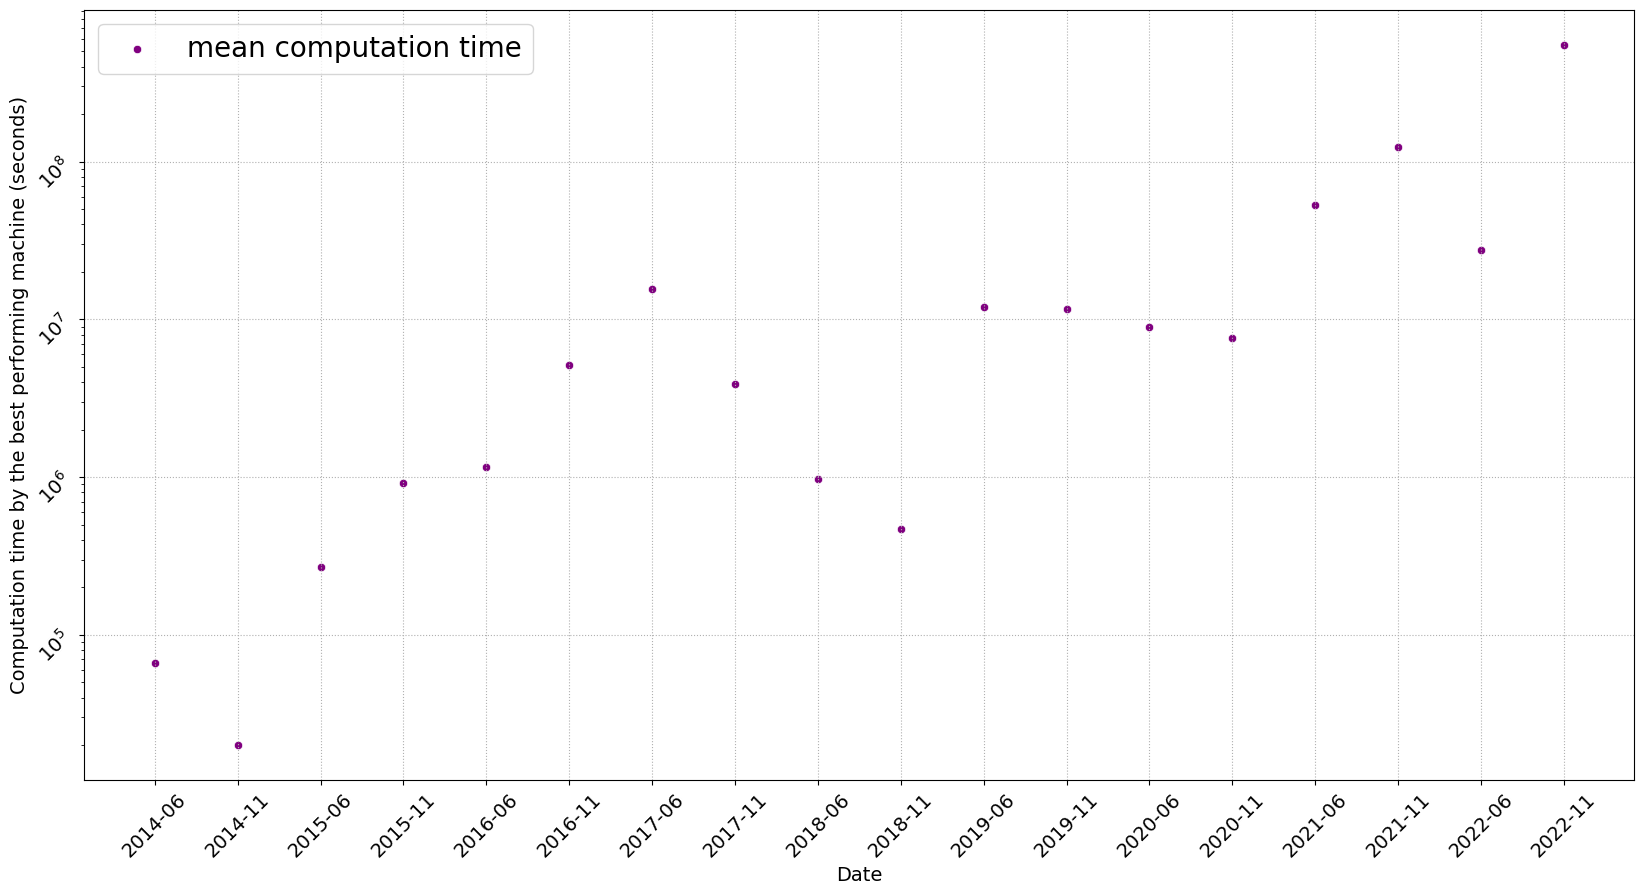

In [19]:

#plt.figure(figsize=(20, 10))
fig, ax = plt.subplots(figsize=(20, 10))

plt.grid(linestyle='dotted') 
plt.yscale('log')

ax = sns.scatterplot(data=cc_df_g[['rank_year', 'hrs_computation']].groupby('rank_year').mean().reset_index(), x='rank_year', y='hrs_computation', label='mean computation time', color='purple')
#sns.lineplot(data=cc_df[['rank_year', 'hrs_computation']].groupby('hrs_computation').mean().reset_index(), x='rank_year', y='hrs_computation',  boxprops=dict(alpha=.4), ax=ax)
#sns.scatterplot(data=cc_df, x='rank_year', y='hrs_computation',  markers=True, hue='Domain', style="Domain",  s=100, alpha=0.9, ax=ax)

#plt.axvline(x = "2013-06", color = 'black', linestyle='-.')

#ax2 = ax.twinx()
#ax2.set_yscale('log')
#ax2 = sns.lineplot(data=cc_df[['rank_year', 'RMax']].groupby('rank_year').max().reset_index(), x='rank_year', y='RMax', label='max top500', color='purple', linestyle='--', ax=ax2)

for axx in [ax, ax2]:
    axx.set_yscale('log')
    axx.grid(linestyle='dotted')
    axx.tick_params(labelrotation=45, labelsize=7)
    axx.legend(ncol=2, loc=2, fontsize="20")

ax.set_ylabel('Computation time by the best performing machine (seconds)', fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

ax2.set_ylabel('Rmax (GFlops)', fontsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.legend(loc=4)
# Axis settings
# plt.legend(ncol=3, loc=2,fontsize='14')
# plt.xticks(rotation=45, ha='right', fontsize=14)
# plt.yticks(rotation=45, ha='right', fontsize=14)
# plt.tight_layout()

plt.xlabel(r'Date', fontsize=14)
#plt.ylabel(r'Computation hours by the best performing machine', fontsize=14)

#plt.savefig('figures/sec_computation_by_ai_models.png', format='png', bbox_inches="tight")

Text(0.5, 0, 'Date')

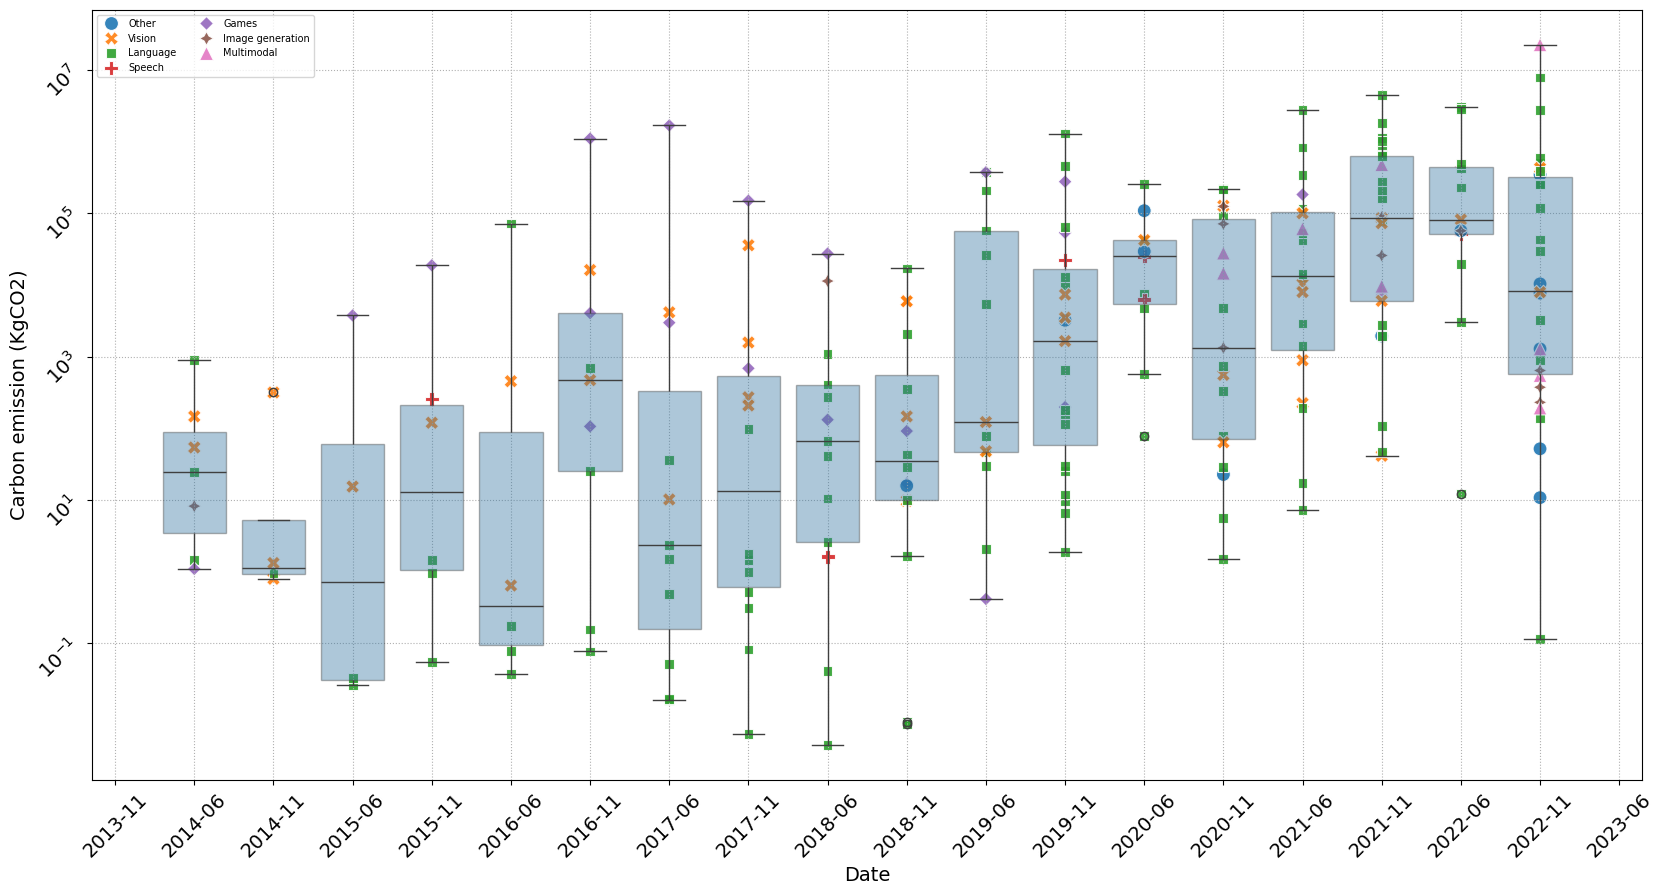

In [17]:

#plt.figure(figsize=(20, 10))
fig, ax = plt.subplots(figsize=(20, 10))

plt.grid(linestyle='dotted') 
plt.yscale('log')

cc_df_g= cc_df_g.sort_values(['rank_year'])
cc_df_g.reset_index(drop=True, inplace=True)
cc_df_g['electricity (kWh)'] = cc_df_g['Power'] * (cc_df_g['hrs_computation'] / 3600)
cc_df_g['emissions (kgCO2)'] = cc_df_g['electricity (kWh)'] * 251 / 1e3


#ax = sns.lineplot(data=cc_df_g[['rank_year', 'hrs_computation']].groupby('rank_year').mean().reset_index(), x='rank_year', y='hrs_computation', label='mean computation time', color='purple')
#sns.boxplot(data=cc_df[['rank_year', 'hrs_computation']].groupby('hrs_computation').mean().reset_index(), x='rank_year', y='hrs_computation',  boxprops=dict(alpha=.4), ax=ax)
sns.boxplot(data=cc_df_g, x='rank_year', y='emissions (kgCO2)',  boxprops=dict(alpha=.4), ax=ax)
sns.scatterplot(data=cc_df_g, x='rank_year', y='emissions (kgCO2)',  markers=True, hue='Domain', style="Domain",  s=100, alpha=0.9, ax=ax)

#plt.axvline(x = "2013-06", color = 'black', linestyle='-.')

#ax2 = ax.twinx()
#ax2.set_yscale('log')
#ax2 = sns.lineplot(data=cc_df[['rank_year', 'RMax']].groupby('rank_year').max().reset_index(), x='rank_year', y='RMax', label='max top500', color='purple', linestyle='--', ax=ax2)

for axx in [ax, ax2]:
    axx.set_yscale('log')
    axx.grid(linestyle='dotted')
    axx.tick_params(labelrotation=45, labelsize=7)
    axx.legend(ncol=2, loc=2, fontsize="7")

ax.set_ylabel('Carbon emission (KgCO2)', fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

ax2.set_ylabel('Rmax (GFlops)', fontsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.legend(loc=4)
# Axis settings
# plt.legend(ncol=3, loc=2,fontsize='14')
# plt.xticks(rotation=45, ha='right', fontsize=14)
# plt.yticks(rotation=45, ha='right', fontsize=14)
# plt.tight_layout()

plt.xlabel(r'Date', fontsize=14)
#plt.ylabel(r'Computation hours by the best performing machine', fontsize=14)

#plt.savefig('figures/sec_computation_by_ai_models.png', format='png', bbox_inches="tight")

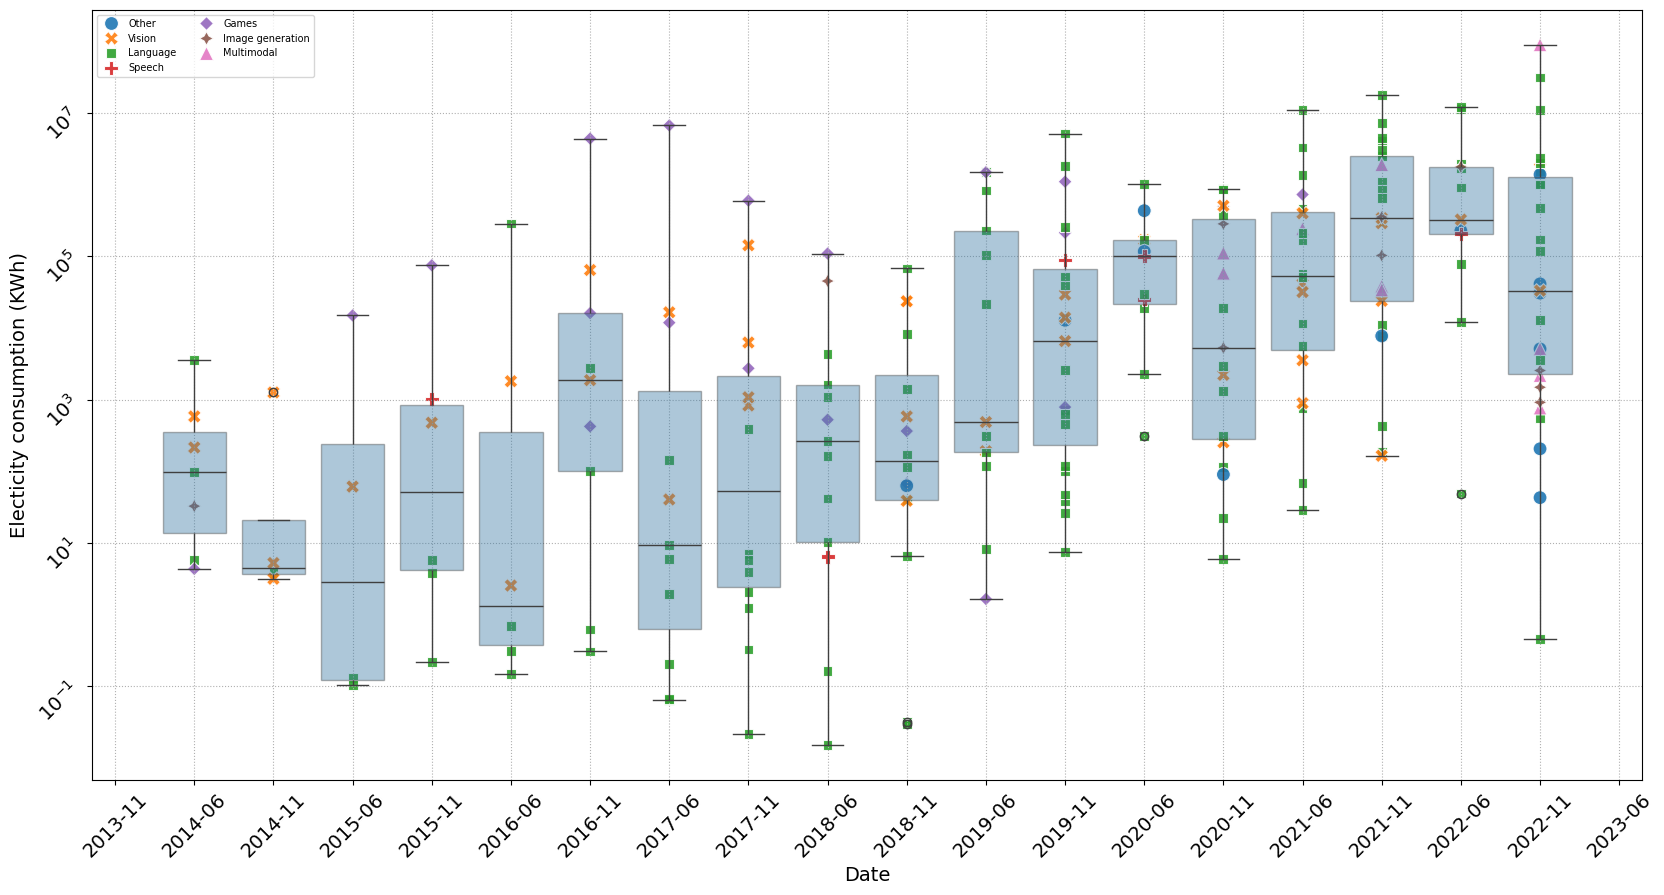

In [18]:

#plt.figure(figsize=(20, 10))
fig, ax = plt.subplots(figsize=(20, 10))

plt.grid(linestyle='dotted') 
plt.yscale('log')

cc_df_g= cc_df_g.sort_values(['rank_year'])
cc_df_g.reset_index(drop=True, inplace=True)
cc_df_g['electricity (kWh)'] = cc_df_g['Power'] * (cc_df_g['hrs_computation'] / 3600)
cc_df_g['emissions (kgCO2)'] = cc_df_g['electricity (kWh)'] * 251 / 1e3


#ax = sns.lineplot(data=cc_df_g[['rank_year', 'hrs_computation']].groupby('rank_year').mean().reset_index(), x='rank_year', y='hrs_computation', label='mean computation time', color='purple')
#sns.boxplot(data=cc_df[['rank_year', 'hrs_computation']].groupby('hrs_computation').mean().reset_index(), x='rank_year', y='hrs_computation',  boxprops=dict(alpha=.4), ax=ax)
sns.boxplot(data=cc_df_g, x='rank_year', y='electricity (kWh)',  boxprops=dict(alpha=.4), ax=ax)
sns.scatterplot(data=cc_df_g, x='rank_year', y='electricity (kWh)',  markers=True, hue='Domain', style="Domain",  s=100, alpha=0.9, ax=ax)

#plt.axvline(x = "2013-06", color = 'black', linestyle='-.')

#ax2 = ax.twinx()
#ax2.set_yscale('log')
#ax2 = sns.lineplot(data=cc_df[['rank_year', 'RMax']].groupby('rank_year').max().reset_index(), x='rank_year', y='RMax', label='max top500', color='purple', linestyle='--', ax=ax2)

for axx in [ax, ax2]: 
    axx.set_yscale('log')
    axx.grid(linestyle='dotted')
    axx.tick_params(labelrotation=45, labelsize=7)
    axx.legend(ncol=2, loc=2, fontsize="7")

ax.set_ylabel('Electicity consumption (KWh)', fontsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)

ax2.set_ylabel('Rmax (GFlops)', fontsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax2.legend(loc=4)
# Axis settings
# plt.legend(ncol=3, loc=2,fontsize='14')
# plt.xticks(rotation=45, ha='right', fontsize=14)
# plt.yticks(rotation=45, ha='right', fontsize=14)
# plt.tight_layout()

plt.xlabel(r'Date', fontsize=14)
#plt.ylabel(r'Computation hours by the best performing machine', fontsize=14)

plt.savefig('figures/elec_consumption_by_ai_models.png', format='png', bbox_inches="tight")